In [14]:
!pip install transformers

**Data**/**Bert**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

from google.colab import files
uploaded = files.upload()

df = pd.read_excel('mr-porter_filtered.xlsx')
df.head()

Saving mr-porter_filtered.xlsx to mr-porter_filtered.xlsx


,brand,description,price_usd,type
0,NIKE,Zoom Vomero 5 Rubber-Trimmed Mesh and Leather ...,160,shoes
1,NIKE,Dunk Low Retro PRM NBHD Leather-Trimmed Canvas...,120,shoes
2,SAINT LAURENT,Teddy Polished-Leather Monk-Strap Boots,1190,shoes
3,BALENCIAGA,3XL Distressed Mesh and Rubber Sneakers,1150,shoes
4,DUNHILL,Audley Leather Penny Loafers,875,shoes


In [3]:
X_desc = df['description'].values
X_price = df['price_usd'].values
y_brand = df['brand'].values

scaler = MinMaxScaler()
X_price_scaled = scaler.fit_transform(X_price.reshape(-1, 1))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 50
X_desc_tokenized = [tokenizer.encode(desc, max_length=max_length, padding='max_length', truncation=True) for desc in X_desc]
X_desc_tokenized = np.array(X_desc_tokenized)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate

def create_model(max_length, tokenizer, num_classes):

    bert_input = Input(shape=(max_length,), dtype=tf.int32, name="description_input")
    bert_embedding = tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=768, input_length=max_length)(bert_input)
    cnn_layer1 = Conv1D(128, 5, activation='relu')(bert_embedding)
    cnn_layer2 = Conv1D(64, 5, activation='relu')(cnn_layer1)
    cnn_layer3 = Conv1D(32, 5, activation='relu')(cnn_layer2)
    pooling_layer = GlobalMaxPooling1D()(cnn_layer3)

    price_input = Input(shape=(1,), name="price_input")

    concat_layer = Concatenate()([pooling_layer, price_input])

    dense_layer = Dense(64, activation='relu')(concat_layer)
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)

    model = Model(inputs=[bert_input, price_input], outputs=output_layer)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = create_model(max_length, tokenizer, len(df['brand'].unique()))
model.summary()

brand_mapping = {brand: i for i, brand in enumerate(df['brand'].unique())}
y_brand_encoded = np.array([brand_mapping[brand] for brand in y_brand])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ description_input         │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 768)        │     23,440,896 │ description_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 46, 128)        │        491,648 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 42, 64)         │         41,024 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 38, 32)         │         10,272 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 32)             │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 33)             │              0 │ global_max_pooling1d[… │
│                           │                        │                │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          2,176 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 18)             │          1,170 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,987,186 (91.50 MB)

 Trainable params: 23,987,186 (91.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 327ms/step - accuracy: 0.1558 - loss: 2.6938
Epoch 2/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 78s 303ms/step - accuracy: 0.4137 - loss: 1.9023
Epoch 3/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.5940 - loss: 1.3323
Epoch 4/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 298ms/step - accuracy: 0.6989 - loss: 0.9850
Epoch 5/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.7603 - loss: 0.7812
Epoch 6/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 313ms/step - accuracy: 0.8047 - loss: 0.6506
Epoch 7/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 303ms/step - accuracy: 0.8300 - loss: 0.5352
Epoch 8/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - accuracy: 0.8474 - loss: 0.4785
Epoch 9/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 381ms/step - accuracy: 0.8735 - loss: 0.4229
Epoch 10/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 75s 324ms/step - accuracy: 0.8746 - loss: 0.3916
Epoch 11/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - accuracy: 0.8934 - loss: 0.3337
Epoch 12

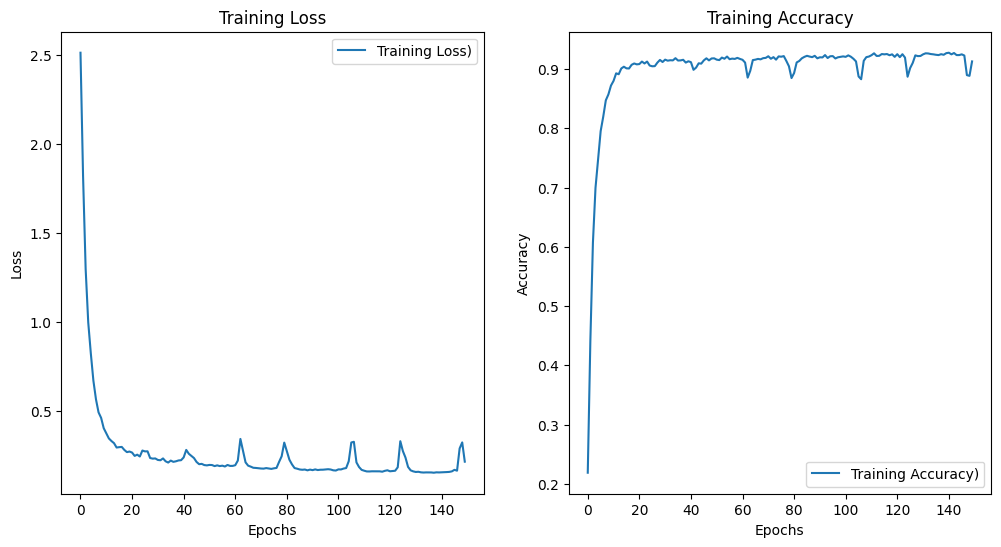

In [ ]:
history = model.fit([X_desc_tokenized, X_price_scaled], y_brand_encoded, epochs=150, batch_size=32)

history_info = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_info['loss'], label=f'Training Loss)')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_info['accuracy'], label=f'Training Accuracy)')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step


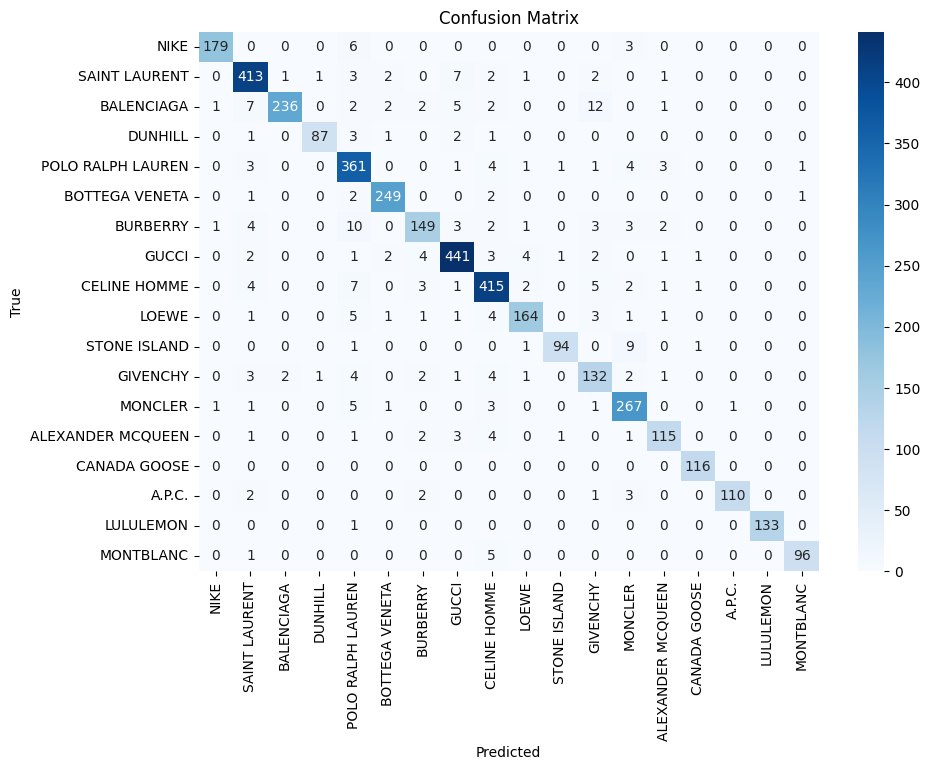

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict([X_desc_tokenized, X_price_scaled])

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_brand_encoded, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['brand'].unique(), yticklabels=df['brand'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 967ms/step - accuracy: 0.1033 - loss: 2.8020
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2540 - loss: 2.4594
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4132 - loss: 1.9692
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5362 - loss: 1.5166
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 951ms/step - accuracy: 0.6570 - loss: 1.1522
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 954ms/step - accuracy: 0.7274 - loss: 0.9385
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7808 - loss: 0.7472
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8189 - loss: 0.6245
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8340 - loss: 0.5704
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 998ms/step - accuracy: 0.8502 - loss: 0.4866
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 963ms/step - accuracy: 0.8591 - loss: 0.4642
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 945m

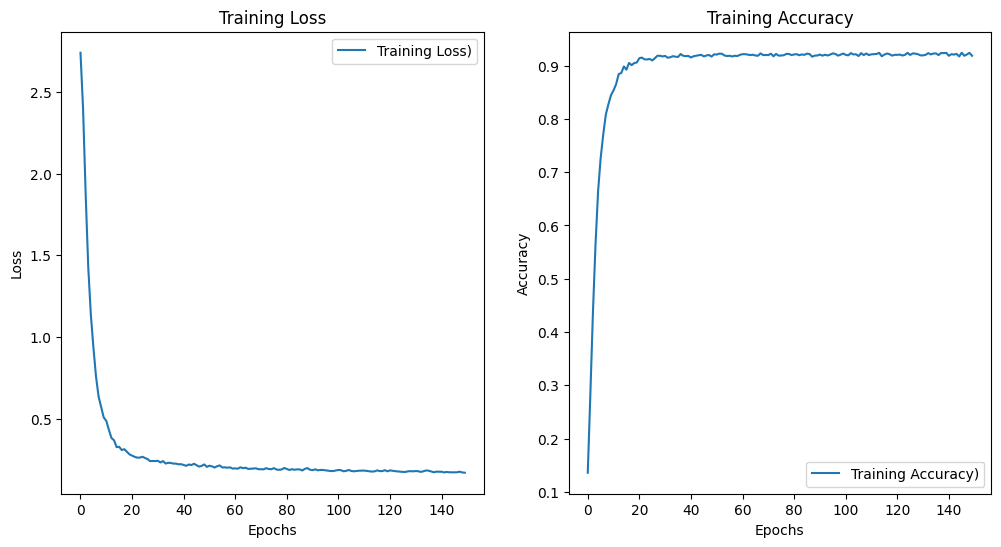

In [6]:
model = create_model(max_length, tokenizer, len(df['brand'].unique()))

history_cnn_bs128 = model.fit([X_desc_tokenized, X_price_scaled], y_brand_encoded, epochs=150, batch_size=128)

history_dict = history_cnn_bs128.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label=f'Training Loss)')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label=f'Training Accuracy)')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


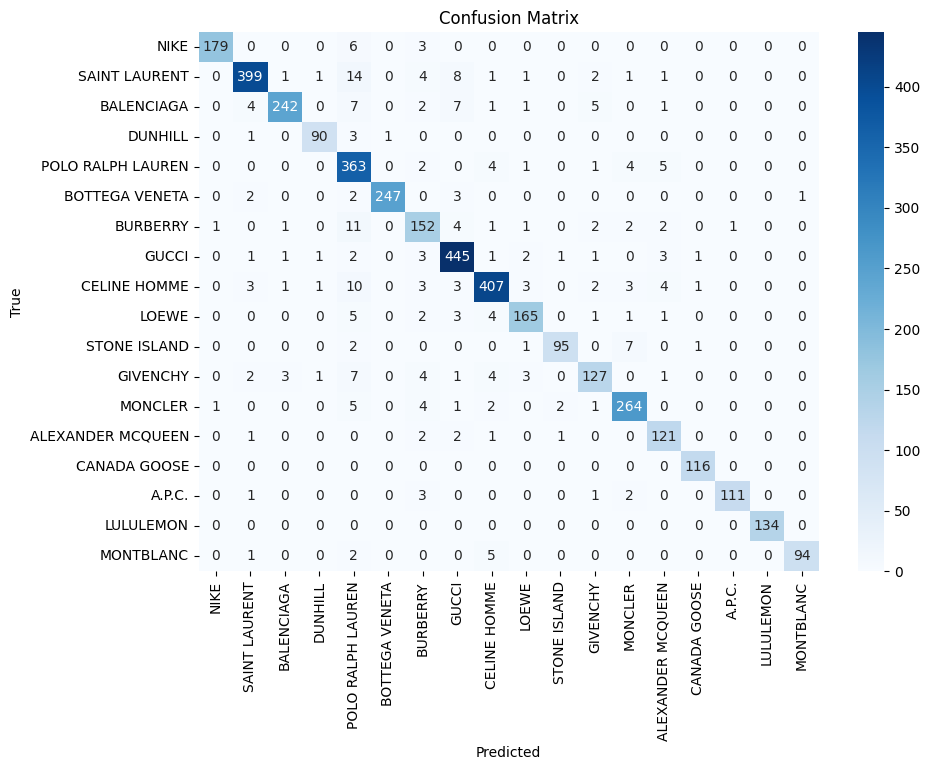

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict([X_desc_tokenized, X_price_scaled])

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_brand_encoded, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['brand'].unique(), yticklabels=df['brand'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**RNN**

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, GlobalMaxPooling1D, Dense, Concatenate

def create_rnn_model(max_length, tokenizer, num_classes):

    bert_input = Input(shape=(max_length,), dtype=tf.int32, name="description_input")
    bert_embedding = tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=768, input_length=max_length)(bert_input)

    rnn_layer = LSTM(128, return_sequences=True)(bert_embedding)
    rnn_layer1 = LSTM(64, return_sequences=True)(rnn_layer)
    rnn_layer2 = LSTM(32, return_sequences=True)(rnn_layer1)
    rnn_layer = GlobalMaxPooling1D()(rnn_layer2)

    price_input = Input(shape=(1,), name="price_input")

    concat_layer = Concatenate()([rnn_layer, price_input])

    dense_layer = Dense(64, activation='relu')(concat_layer)
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)

    model = Model(inputs=[bert_input, price_input], outputs=output_layer)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

num_classes = len(df['brand'].unique())

model = create_rnn_model(max_length, tokenizer, num_classes)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ description_input         │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 50, 768)        │     23,440,896 │ description_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 50, 128)        │        459,264 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 50, 64)         │         49,408 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 50, 32)         │         12,416 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 32)             │              0 │ lstm_2[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 33)             │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          2,176 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 18)             │          1,170 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,965,330 (91.42 MB)

 Trainable params: 23,965,330 (91.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 48s 384ms/step - accuracy: 0.9346 - loss: 0.1533
Epoch 2/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 376ms/step - accuracy: 0.9349 - loss: 0.1535
Epoch 3/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 372ms/step - accuracy: 0.9300 - loss: 0.1581
Epoch 4/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 47s 372ms/step - accuracy: 0.9365 - loss: 0.1502
Epoch 5/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 368ms/step - accuracy: 0.9337 - loss: 0.1566
Epoch 6/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 83s 375ms/step - accuracy: 0.9343 - loss: 0.1483
Epoch 7/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 370ms/step - accuracy: 0.9352 - loss: 0.1453
Epoch 8/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9319 - loss: 0.1537
Epoch 9/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - accuracy: 0.9326 - loss: 0.1555
Epoch 10/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 368ms/step - accuracy: 0.9361 - loss: 0.1419
Epoch 11/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 367ms/step - accuracy: 0.9353 - loss: 0.1490
Epoch 12

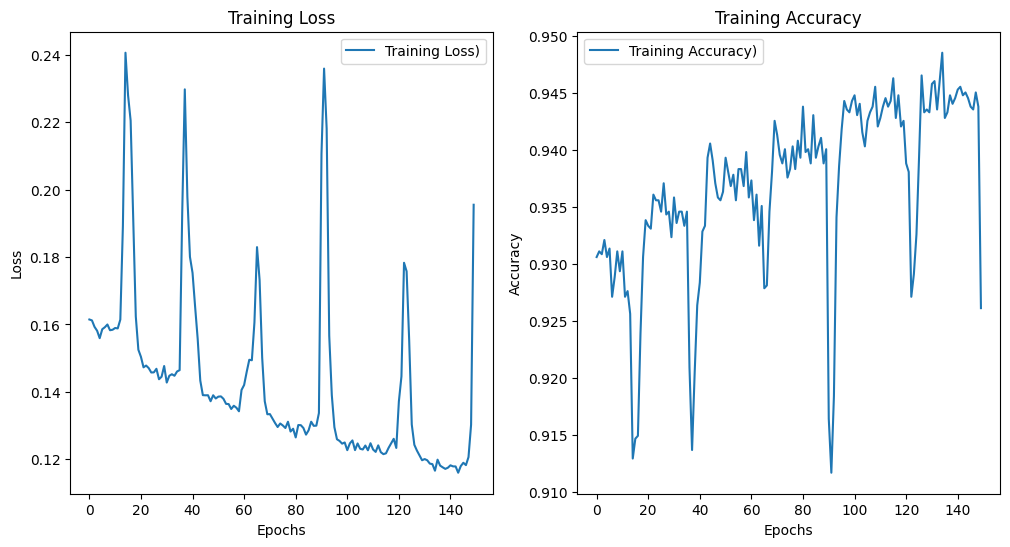

In [ ]:
history = model.fit([X_desc_tokenized, X_price_scaled], y_brand_encoded, epochs=150, batch_size=32)

history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss)')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy)')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 561ms/step - accuracy: 0.0944 - loss: 2.8309
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 578ms/step - accuracy: 0.2278 - loss: 2.5619
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 581ms/step - accuracy: 0.3185 - loss: 2.2431
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 566ms/step - accuracy: 0.4403 - loss: 1.9455
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 591ms/step - accuracy: 0.5215 - loss: 1.7295
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 563ms/step - accuracy: 0.5596 - loss: 1.5652
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 550ms/step - accuracy: 0.5892 - loss: 1.4482
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 562ms/step - accuracy: 0.6063 - loss: 1.3399
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 549ms/step - accuracy: 0.6313 - loss: 1.2383
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 550ms/step - accuracy: 0.6772 - loss: 1.1654
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 551ms/step - accuracy: 0.6963 - loss: 1.0996
Epoch 12/150
32/32 ━━━━━━━━━━━

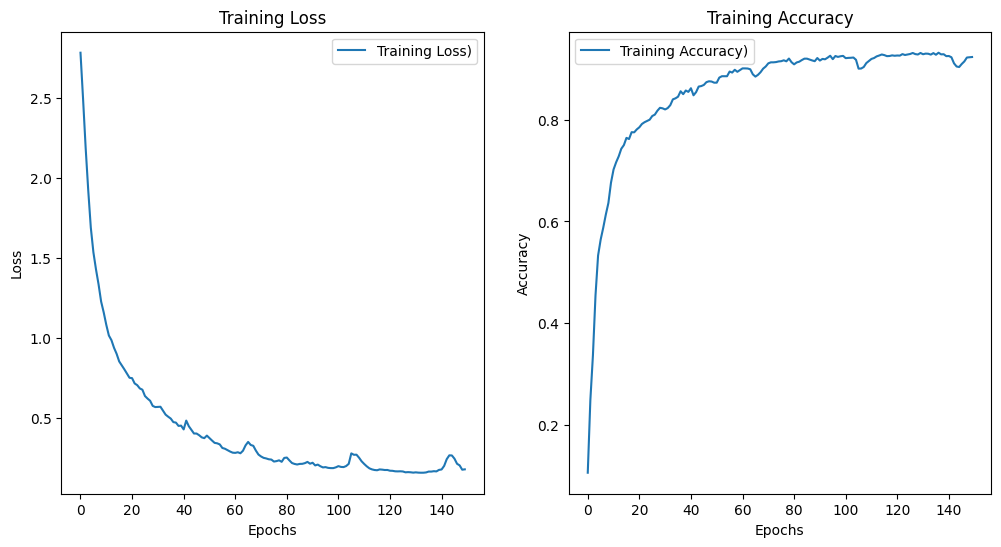

In [ ]:
model = create_rnn_model(max_length, tokenizer, num_classes)
history = model.fit([X_desc_tokenized, X_price_scaled], y_brand_encoded, epochs=150, batch_size=128)

history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss)')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy)')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step


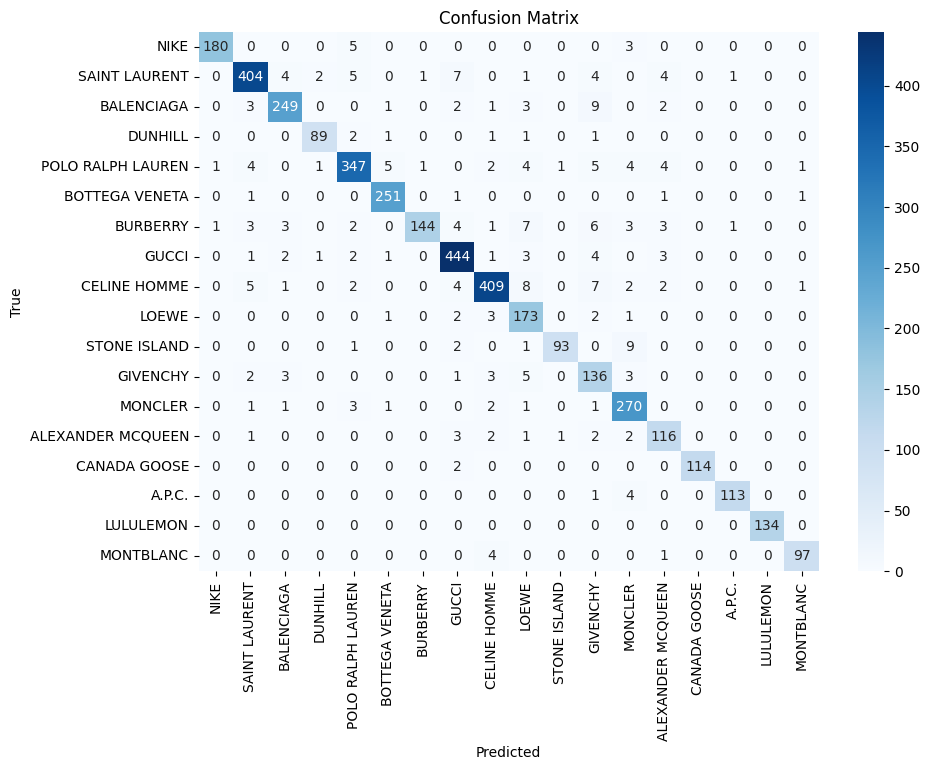

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict([X_desc_tokenized, X_price_scaled])

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_brand_encoded, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['brand'].unique(), yticklabels=df['brand'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - accuracy: 0.1344 - loss: 2.7382
Epoch 2/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 353ms/step - accuracy: 0.4151 - loss: 1.9958
Epoch 3/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - accuracy: 0.5354 - loss: 1.5818
Epoch 4/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - accuracy: 0.5943 - loss: 1.3630
Epoch 5/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 360ms/step - accuracy: 0.6475 - loss: 1.2116
Epoch 6/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 46s 366ms/step - accuracy: 0.6887 - loss: 1.1085
Epoch 7/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 361ms/step - accuracy: 0.6979 - loss: 1.0586
Epoch 8/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 364ms/step - accuracy: 0.7483 - loss: 0.9160
Epoch 9/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 46s 364ms/step - accuracy: 0.7541 - loss: 0.8482
Epoch 10/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 361ms/step - accuracy: 0.7591 - loss: 0.8169
Epoch 11/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7650 - loss: 0.8087
Epoch 12/75
126/126

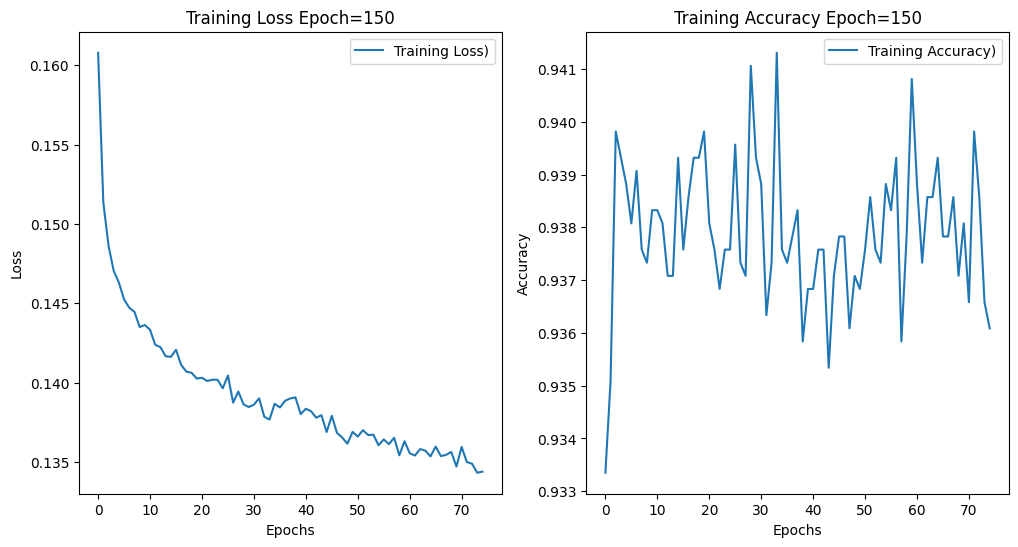

In [ ]:
model = create_rnn_model(max_length, tokenizer, num_classes)
history1 = model.fit([X_desc_tokenized, X_price_scaled],
            y_brand_encoded, epochs=75, batch_size=32)
history = model.fit([X_desc_tokenized, X_price_scaled],
            y_brand_encoded, epochs=75, batch_size=128)

history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss)')
plt.title('Training Loss Epoch=150')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy)')
plt.title('Training Accuracy Epoch=150')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

**RNN AND CNN**

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, GRU

def create_mix_model(max_length, tokenizer, num_classes):

    bert_input = Input(shape=(max_length,), dtype=tf.int32, name="description_input")
    bert_embedding = tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=768, input_length=max_length)(bert_input)

    rnn_layer = LSTM(128, return_sequences=True)(bert_embedding)
    rnn_layer = LSTM(64, return_sequences=True)(rnn_layer)
    rnn_layer = LSTM(32, return_sequences=True)(rnn_layer)
    rnn_layer = LSTM(16, return_sequences=True)(rnn_layer)

    cnn_layer = Conv1D(128, 5, activation='relu')(rnn_layer)
    cnn_layer = Conv1D(64, 5, activation='relu')(cnn_layer)
    cnn_layer = Conv1D(32, 5, activation='relu')(cnn_layer)
    cnn_pooling_layer = GlobalMaxPooling1D()(cnn_layer)

    price_input = Input(shape=(1,), name="price_input")

    concat_layer = Concatenate()([cnn_pooling_layer, price_input])

    dense_layer = Dense(64, activation='relu')(concat_layer)
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)
    model = Model(inputs=[bert_input, price_input], outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = create_mix_model(max_length, tokenizer, num_classes)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ description_input         │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 50, 768)        │     23,440,896 │ description_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 50, 128)        │        459,264 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 50, 64)         │         49,408 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 50, 32)         │         12,416 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 50, 16)         │          3,136 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 46, 128)        │         10,368 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 42, 64)         │         41,024 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 38, 32)         │         10,272 │ conv1d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 32)             │              0 │ conv1d_8[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 33)             │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          2,176 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 18)             │          1,170 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,030,130 (91.67 MB)

 Trainable params: 24,030,130 (91.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 422ms/step - accuracy: 0.1197 - loss: 2.7720
Epoch 2/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 56s 443ms/step - accuracy: 0.2284 - loss: 2.4314
Epoch 3/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - accuracy: 0.2849 - loss: 2.1479
Epoch 4/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 83s 462ms/step - accuracy: 0.3521 - loss: 1.9736
Epoch 5/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 80s 447ms/step - accuracy: 0.4751 - loss: 1.6905
Epoch 6/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 84s 467ms/step - accuracy: 0.5458 - loss: 1.4911
Epoch 7/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 80s 453ms/step - accuracy: 0.5902 - loss: 1.4260
Epoch 8/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.6107 - loss: 1.2925
Epoch 9/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 459ms/step - accuracy: 0.6305 - loss: 1.2397
Epoch 10/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 458ms/step - accuracy: 0.6540 - loss: 1.1524
Epoch 11/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 461ms/step - accuracy: 0.6656 - loss: 1.1104
Epoch 12

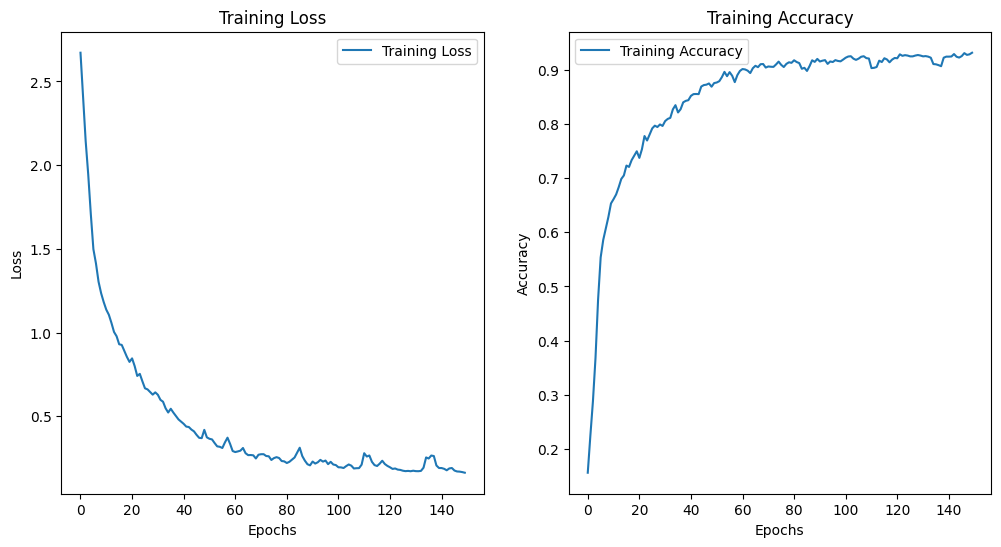

In [ ]:
history = model.fit([X_desc_tokenized, X_price_scaled], y_brand_encoded, epochs=150, batch_size=32)

history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step


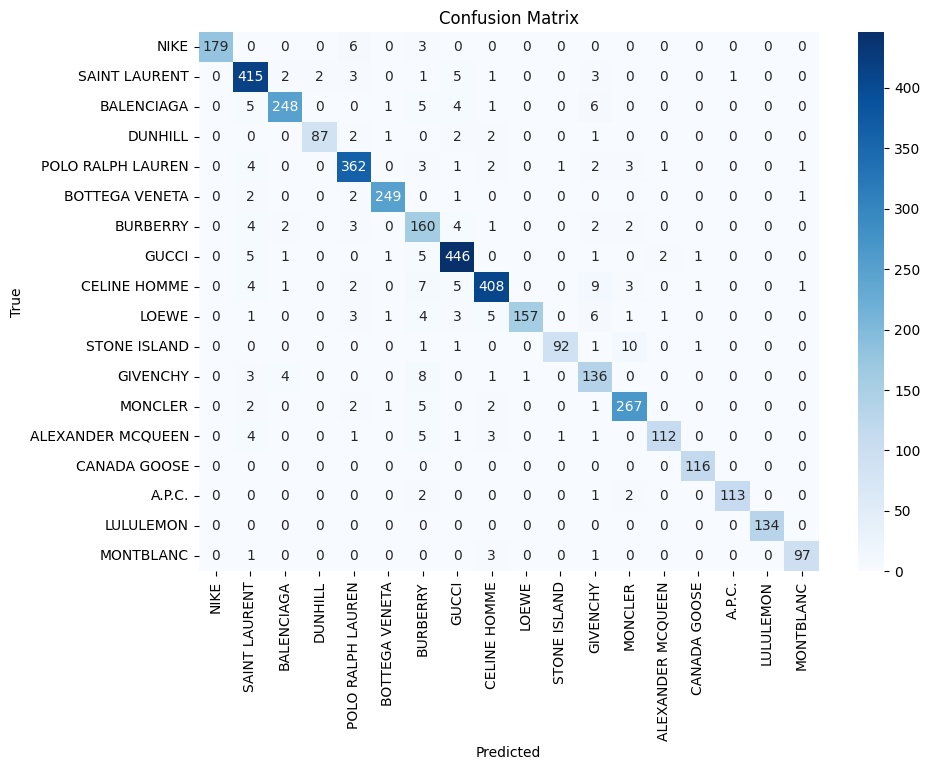

In [ ]:
y_pred = model.predict([X_desc_tokenized, X_price_scaled])

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_brand_encoded, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['brand'].unique(), yticklabels=df['brand'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0747 - loss: 2.8478
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1819 - loss: 2.6129
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2456 - loss: 2.3403
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3154 - loss: 2.1074
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3820 - loss: 1.9255
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4539 - loss: 1.7524
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5351 - loss: 1.5435
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5650 - loss: 1.4332
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5981 - loss: 1.3026
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6367 - loss: 1.1975
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6527 - loss: 1.1225
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy:

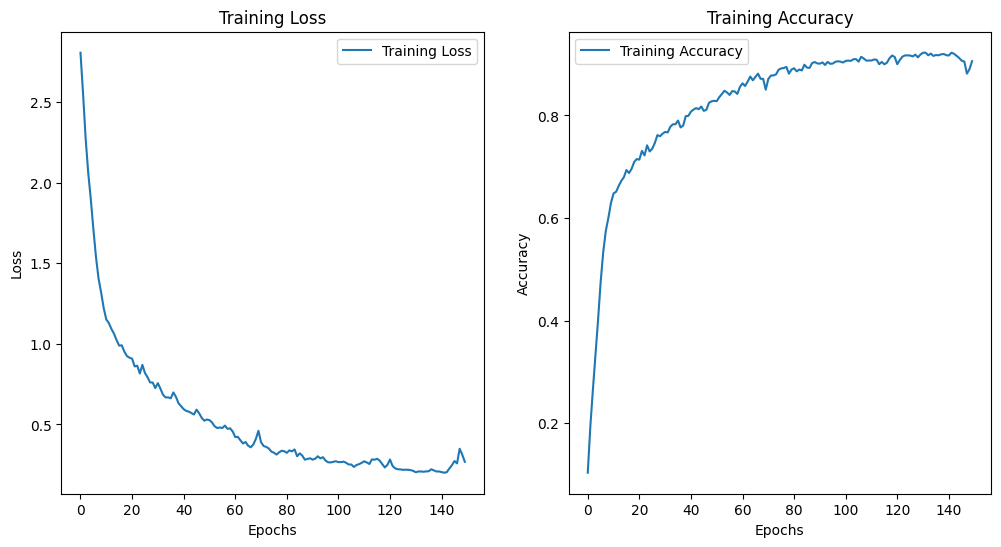

In [18]:
model = create_mix_model(max_length, tokenizer, num_classes)
history = model.fit([X_desc_tokenized, X_price_scaled], y_brand_encoded, epochs=150, batch_size=128)

history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step


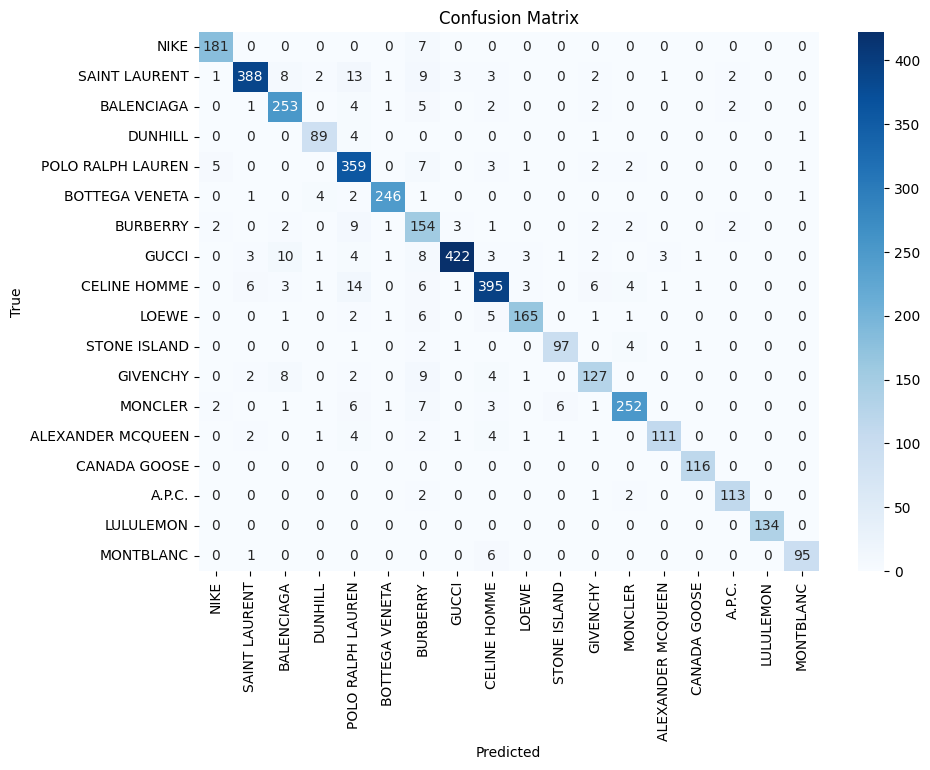

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict([X_desc_tokenized, X_price_scaled])

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_brand_encoded, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['brand'].unique(), yticklabels=df['brand'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
def create_mixlite_model(max_length, tokenizer, num_classes):

    bert_input = Input(shape=(max_length,), dtype=tf.int32, name="description_input")
    bert_embedding = tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=768, input_length=max_length)(bert_input)

    rnn_layer = LSTM(128, return_sequences=True)(bert_embedding)
    rnn_layer = LSTM(64, return_sequences=True)(rnn_layer)

    cnn_layer = Conv1D(128, 5, activation='relu')(rnn_layer)
    cnn_layer = Conv1D(64, 5, activation='relu')(cnn_layer)
    cnn_pooling_layer = GlobalMaxPooling1D()(cnn_layer)

    price_input = Input(shape=(1,), name="price_input")
    concat_layer = Concatenate()([cnn_pooling_layer, price_input])

    dense_layer = Dense(64, activation='relu')(concat_layer)
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)

    model = Model(inputs=[bert_input, price_input], outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.1072 - loss: 2.8128
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2275 - loss: 2.4531
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4101 - loss: 1.9048
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5371 - loss: 1.5392
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6098 - loss: 1.3109
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6440 - loss: 1.1851
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6820 - loss: 1.0920
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6951 - loss: 1.0071
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7177 - loss: 0.9629
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7267 - loss: 0.8825
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7384 - loss: 0.8453
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy:

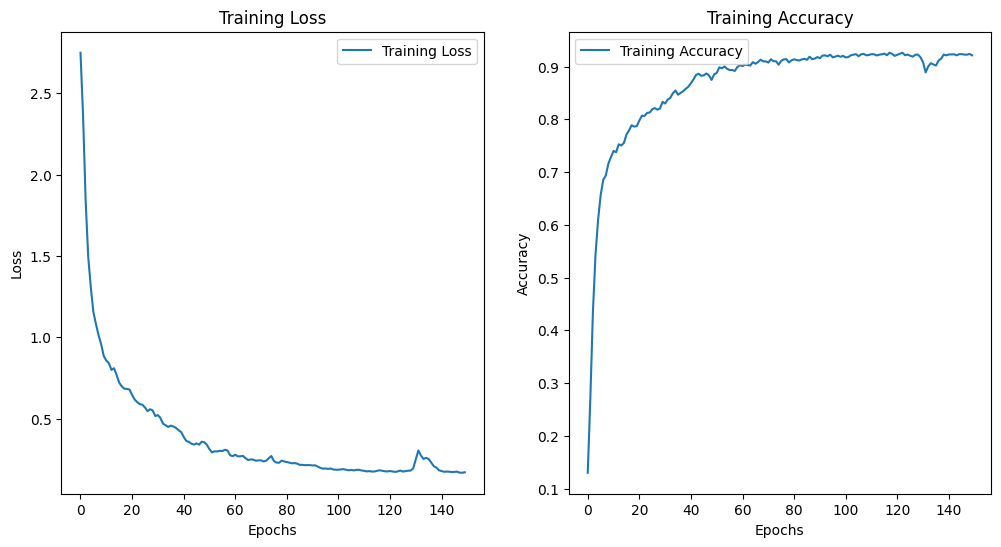

In [21]:
model = create_mixlite_model(max_length, tokenizer, num_classes)
history = model.fit([X_desc_tokenized, X_price_scaled], y_brand_encoded, epochs=150, batch_size=128)

history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step


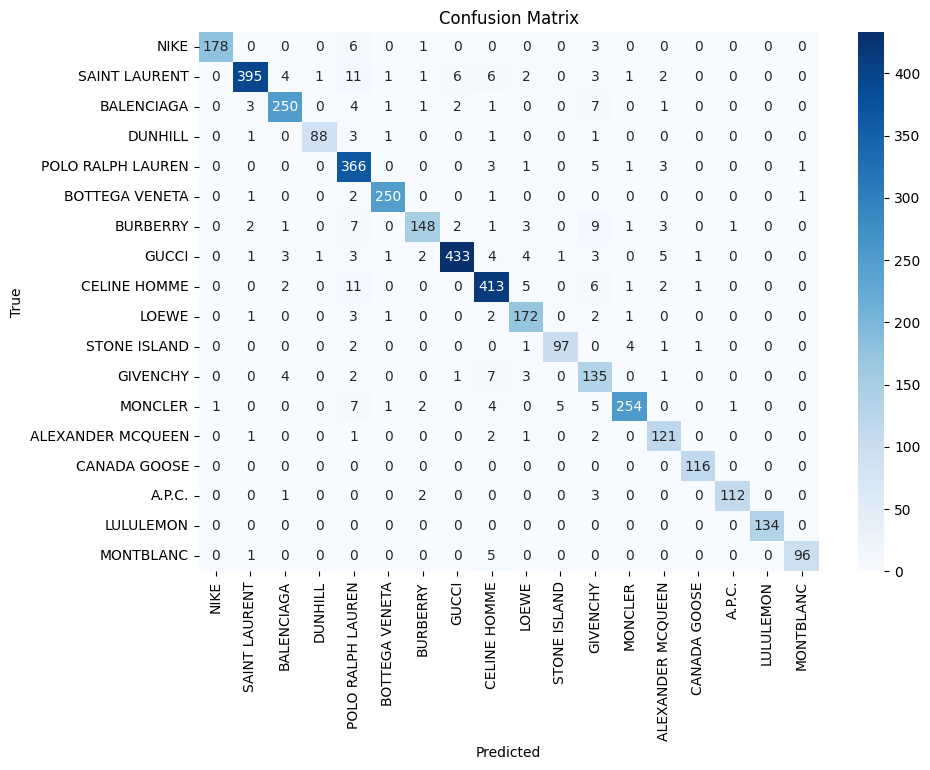

In [22]:
y_pred = model.predict([X_desc_tokenized, X_price_scaled])

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_brand_encoded, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['brand'].unique(), yticklabels=df['brand'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()